# EX4-BATCH: Introduction to Spark programming

Your assignment: complete the `TODO`'s and include also the **output of each cell**.

### Step 1: First Spark program

Important observations:

- This code corresponds to the **driver program** and hence, it must connect to a **Spark master**.
- You have some options to the Spark Master: in lab we should have a Spark service available at `spark://spark:7077`. But you can also run this code locally with `local[*]` as the master parameter -- this means that driver and executors are going to be deployed in you machine. *Program once, run everywhere*.
- The SparkContext is started and stopped in the cell below -- this means that the application will finish after. If you need to keep the application alive, do not call `sc.stop()` until finished.

In [2]:
from pyspark.context import SparkContext

try:
    sc.stop()
except NameError:
    print("SparkContext not defined")    

# ---- Local execution
sc = SparkContext(appName="SparkStarters", master="local[*]")

# ---- Distributed execution
# sc = SparkContext(appName="SparkStarters", master="spark://spark:7077")

rdd1 = sc.parallelize([1, 2, 3, 4, 5])
rdd2 = sc.parallelize(['one', 'two', 'three'])

sum_rdd1 = rdd1.sum()
avg_rdd1 = rdd1.mean()

print("Sum of RDD1: ", sum_rdd1)
print("Average of RDD1: ", avg_rdd1)

word_count = rdd2.countByValue()
for word, count in word_count.items():
    print(word, ":", count)

sc.stop()

Sum of RDD1:  15
Average of RDD1:  3.0
one : 1
two : 1
three : 1


### Step 2: Quick start tutorial on Spark RDD API `#TODO`

1. Complete the [SparkByExample RDD tutorial](https://sparkbyexamples.com/pyspark-rdd/) **(from step 1 to step 10 only)**.
2. Include here in this notebook (add cells to it): the commands, the explanation of each cell, and the output of each command.
3. In the parts where an input file is required, use some data from the previous classes (e.g. the HDFS log dataset)
4. Take this opportunity to try the operators discussed in class. Also, web UI for inspecting the application running time.

## Breaf explanation

RDD é uma estrutura de dados fundamental do Apache Spark, representando uma coleção imutável e distribuída de objetos, que podem ser processadas em paralelo em um cluster.

Os RDDs são resilientes (tolerantes a falhas), distribuídos (divididos em nós, podendo ser processados paralelamente) e dataset (coleção de registros).

São recomendados para serem utilizados quando há a presença de dados não estruturados e/ou quando temos a necessidade de maior controle dos dados e processos.  

### Downloading the hdfs data

In [3]:
![ -e "data/hdfs/HDFS.log" ] || (wget https://zenodo.org/records/8196385/files/HDFS_v1.zip -P data/ && unzip -o data/HDFS_v1.zip -d data/hdfs && rm data/HDFS_v1.zip)

Connecting to zenodo.org (188.185.45.92:443)
saving to 'data/HDFS_v1.zip'
HDFS_v1.zip          100% |********************************|  177M  0:00:00 ETA
'data/HDFS_v1.zip' saved
Archive:  data/HDFS_v1.zip
  inflating: HDFS.log
   creating: preprocessed/
  inflating: preprocessed/anomaly_label.csv
  inflating: preprocessed/Event_occurrence_matrix.csv
  inflating: preprocessed/Event_traces.csv
  inflating: preprocessed/HDFS.log_templates.csv
  inflating: preprocessed/HDFS.npz
  inflating: README.md


### Criação de uma instância de SparkSession

1. builder: inicia a construção da sessão do Spark
2. master("local[16]"): define que o Spark vai rodar localmente e 16 significa a quantidade de threads
3. appName("SparkByExamples.com"): dá um nome à aplicação
4. getOrCreate(): tenta obter uma sessão Spark existente, se não existir, uma nova é criada

In [1]:
# Imports
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession.builder.master("local[16]").appName("SparkByExamples.com").getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/16 01:35:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Criação de um RDD a partir de uma Coleção

1. Uma lista de números é criada e atribuida a uma variável data
2. A lista é transformada em um RDD distribuído no Spark
3. O parallelize(data) cria um RDD e distribui os dados entre os workers
4. O output ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:289 é uma descrição técnica do objeto RDD

In [2]:
# Create RDD from parallelize    
data = [1,2,3,4,5,6,7,8,9,10,11,12]
rdd = spark.sparkContext.parallelize(data)
rdd

ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:289

### Criação de um RDD a partir de um Arquivo Externo

1. Lê um arquivo linha por linha, transformando cada uma das linhas em um elemento do RDD
2. O RDD criado é do tipo TextFileRDD
3. Exemplo:
Entrada de arquivo:

     Linha 1

     Linha 2

     Linha 3

Formato no RDD:
['linha 1', 'linha 2', 'linha 3']

In [4]:
# Create RDD from external Data source
rdd2 = spark.sparkContext.textFile("data/hdfs/HDFS.log")
rdd2

data/hdfs/HDFS.log MapPartitionsRDD[2] at textFile at NativeMethodAccessorImpl.java:0

1. Lê um ou mais arquivos de texto (pode ser um diretório com vários arquivos)
2. Retorna um RDD de pares (tuplas)
3. Cada arquivo vira um registro único no RDD, e o conteúdo inteiro do arquivo é armazenado como uma string
4. A diferença do wholeTextFiles() para o textFile() é que ele guarda um arquivo inteiro como string (como um documento JSON, XML, e ou textos)
5. Formato no RDD: [('file:/caminho/para/exemplo.txt', 'linha 1\nlinha 2\nlinha 3')]

In [5]:
# Read entire file into a RDD as single record.
rdd3 = spark.sparkContext.wholeTextFiles("data/hdfs/HDFS.log")
rdd3

org.apache.spark.api.java.JavaPairRDD@62bd7c6a

### Criando um RDD vazio

1. Um RDD é criado sem nenhum dado contido
2. Esse RDD não tem partições atribuídas por padrão
3. Pode ser usado como ponto de partida para transformar e unir com outros RDDs
4. Da para ser criado como rdd = spark.sparkContext.parallelize([], numSlices=1), caso queira estipular o número de partições 

In [15]:
# Create an empty RDD with no partition    
rdd4 = spark.sparkContext.emptyRDD 
rdd4

<bound method SparkContext.emptyRDD of <SparkContext master=local[16] appName=SparkByExamples.com>>

In [6]:
# Create empty RDD with partition
rdd5 = spark.sparkContext.parallelize([],10) #This creates 10 partitions
rdd5

ParallelCollectionRDD[5] at readRDDFromFile at PythonRDD.scala:289

### Número de Partições 

É possível ter conhecimento do número de partições a partir da função getNumPartitions()

In [7]:
# Get partition count
print("Initial partition count:"+str(rdd.getNumPartitions()))

Initial partition count:16


### Criações de Partições Manualmente

1. É criado um RDD a partir de uma lista fornecida e em seguida é definido o npumero de partições que o RDD terá. Funciona com a mesma estrutura de criar um RDD vazio, mas com partições definidas
2. Se você tiver muitos dados e precisar de paralelismo mais fino, pode aumentar ou diminuir o número de partições
3. A função repartition pode ser utilizada para ajustar novamente o número de partições
4. Há a possibilidade de utilizar a função coalesce() para casos que se deseja reduzir o número de partições de forma mais eficiente. O Spark combina partições existentes para reduzir o número total de partições para n.

In [8]:
# Set partitions manually
spark.sparkContext.parallelize([1,2,3,4,56,7,8,9,12,3], 10)

ParallelCollectionRDD[6] at readRDDFromFile at PythonRDD.scala:289

In [9]:
# Repartition the RDD
reparRdd = rdd.repartition(4)
print("re-partition count:"+str(reparRdd.getNumPartitions()))

re-partition count:4


### Lendo novamente o HDFS

In [10]:
# Create RDD from external Data source
rdd = spark.sparkContext.textFile("data/hdfs/HDFS.log")
rdd

data/hdfs/HDFS.log MapPartitionsRDD[13] at textFile at NativeMethodAccessorImpl.java:0

### flatMap( )

1. Neste caso, estamos realizando uma transformação para dividir os dados de cada item do RDD por um espaço (" ") e depois achatar (flatten) o resultado.
2. Exemplo:

- Entrada: rdd = spark.sparkContext.parallelize(["Olá mundo", "Como vai você", "Isso é PySpark"])

- Saída após o flatMap: ['Olá', 'mundo', 'Como', 'vai', 'você', 'Isso', 'é', 'PySpark'] 

In [11]:
# split the data by spact and flatten it.
rdd2 = rdd.flatMap(lambda x: x.split(" "))

### map( )

1. Aplica uma função para cada elemento do RDD e retorna um novo RDD com os resultados
2. Neste caso, para cada elemento x, a função cria uma tupla no formado (x,1)
3. Exemplo:
- Entrada: rdd2 = spark.sparkContext.parallelize(['Olá', 'mundo', 'Como', 'vai', 'você'])
- Saída após transformação: [('Olá', 1), ('mundo', 1), ('Como', 1), ('vai', 1), ('você', 1)] 

In [12]:
# Apply the mpa() transformation 
# Add a new element with value 1 to each word
rdd3 = rdd2.map(lambda x: (x,1))

### reduceByKey( )

1. Essa transformação reduz os valores para cada chave usando a função fornecida, ou seja, agrupa as palavras e combina os valores das palavras iguais
2. Exemplo:
- Entrada: rdd3 = spark.sparkContext.parallelize([('Olá', 1), ('mundo', 1), ('Como', 1), ('vai', 1), ('você', 1), ('Olá', 1), ('mundo', 1)])
- Saída: [('Olá', 2), ('mundo', 2), ('Como', 1), ('vai', 1), ('você', 1)]


In [13]:
# Use reduceByKey()
rdd4 = rdd3.reduceByKey(lambda a,b: a+b)
rdd4

PythonRDD[18] at RDD at PythonRDD.scala:53

### sortByKey( )

1. Ordena as tuplas com base na chave (da menor qtd pra maior)
2. A função lambda x: (x[1], x[0]) inverte as posições das tuplas
3. Após essa transformação, as tuplas ficam no formato (contagem, palavra)
4. Exemplo:
- Entrada: rdd4 = spark.sparkContext.parallelize([('Olá', 2), ('mundo', 2), ('Como', 1), ('vai', 1), ('você', 1)])
- Saída: [(1, 'Como'), (1, 'vai'), (1, 'você'), (2, 'Olá'), (2, 'mundo')]

In [14]:
# Using sortByKey()
rdd5 = rdd4.map(lambda x: (x[1],x[0])).sortByKey()

# Print rdd5 result to console
limited_result = rdd5.take(5)
print(limited_result)

[Stage 6:>                                                          (0 + 1) / 1]

[(1, '/10.251.127.191:48369'), (1, '/10.251.31.5:53702'), (1, '/10.251.125.193:39521'), (1, '/10.250.17.225:58915'), (1, '/10.251.126.83:36160')]


### count( )

Retorna a quantidade de elementos no rdd

In [15]:
rdd6 = spark.sparkContext.textFile("data/hdfs/HDFS.log")

# Action - count
print("Count : "+str(rdd6.count()))

[Stage 7:======================================>                 (32 + 15) / 47]

Count : 11175629


### first( )

Retorna o primeiro elemento de um RDD

In [16]:
# Action - first
firstRec = rdd5.first()
print("First Record : "+str(firstRec[0]) + ","+ firstRec[1])

[Stage 10:>                                                         (0 + 1) / 1]

First Record : 1,/10.251.127.191:48369


### max( )

Retorna o valor máximo de um RDD

In [17]:
# Action - max
datMax = rdd5.max()
print("Max Record : "+str(datMax[0]) + ","+ datMax[1])

[Stage 13:======================================================> (46 + 1) / 47]

Max Record : 10812836,INFO


### reduce( )
Agrega os elementos de um RDD de acordo com uma função binária definida, neste caso somando o valor das chaves em que o valor é igual

In [18]:
# Action - reduce
totalWordCount = rdd5.reduce(lambda a,b: (a[0]+b[0],a[1]))
print("dataReduce Record : "+str(totalWordCount[0]))

[Stage 16:======================================================> (46 + 1) / 47]

dataReduce Record : 138554843


### take( )

Pega os n primeiros elementos do RDD, e neste caso, imprime cada um deles

In [19]:
# Action - take
data3 = rdd5.take(3)
for f in data3:
    print("data3 Key:"+ str(f[0]) +", Value:"+f[1])

[Stage 19:>                                                         (0 + 1) / 1]

data3 Key:1, Value:/10.251.127.191:48369
data3 Key:1, Value:/10.251.31.5:53702
data3 Key:1, Value:/10.251.125.193:39521


### colect( )

Trás todos os elementos do RDD para o driver

Obs.: Tomar cuidado para não usar collect em bases muito grandes, pois pode travar o pc :(

In [21]:
# Action - collect
data = spark.sparkContext.parallelize([1,2,3,4,56,7,8,9,12,3], 10)
print(data.collect())

[1, 2, 3, 4, 56, 7, 8, 9, 12, 3]


### saveAsTextFile( )

Salva um arquivo de texto com o RDD que foi criado

In [22]:
rdd6.saveAsTextFile("/tmp/wordCount")

### cache( )

Marca o RDD para ser armazenado na memória RAM após a primeira ação executada. Assim, nas próximas vezes que for utilizar o mesmo RDD, ele não será recalculado, e sim lido diretamente da memória, aumentando a eficiência.

In [25]:
# cache()
cachedRdd = rdd6.cache()

### persist( )

Gerencia a cache e armazenamento de dados, podendo salvar na memória, disco, em ambos e etc.


In [27]:
# persist()
import pyspark
dfPersist = rdd6.persist(pyspark.StorageLevel.MEMORY_ONLY)
for item in dfPersist.take(10):
    print(item)

081109 203518 143 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.19.102:54106 dest: /10.250.19.102:50010
081109 203518 35 INFO dfs.FSNamesystem: BLOCK* NameSystem.allocateBlock: /mnt/hadoop/mapred/system/job_200811092030_0001/job.jar. blk_-1608999687919862906
081109 203519 143 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.10.6:40524 dest: /10.250.10.6:50010
081109 203519 145 INFO dfs.DataNode$DataXceiver: Receiving block blk_-1608999687919862906 src: /10.250.14.224:42420 dest: /10.250.14.224:50010
081109 203519 145 INFO dfs.DataNode$PacketResponder: PacketResponder 1 for block blk_-1608999687919862906 terminating
081109 203519 145 INFO dfs.DataNode$PacketResponder: PacketResponder 2 for block blk_-1608999687919862906 terminating
081109 203519 145 INFO dfs.DataNode$PacketResponder: Received block blk_-1608999687919862906 of size 91178 from /10.250.10.6
081109 203519 145 INFO dfs.DataNode$PacketResponder: Receiv

25/04/16 02:40:03 WARN BlockManager: Task 390 already completed, not releasing lock for rdd_27_0


### unpersist( )

Faz com que o Spark remova da memória (ou disco) os dados que foram armazenado anteriormente com cache( ) ou persist( )

In [29]:
# unpersist()
rddPersist2 = dfPersist.unpersist()

# Jobs

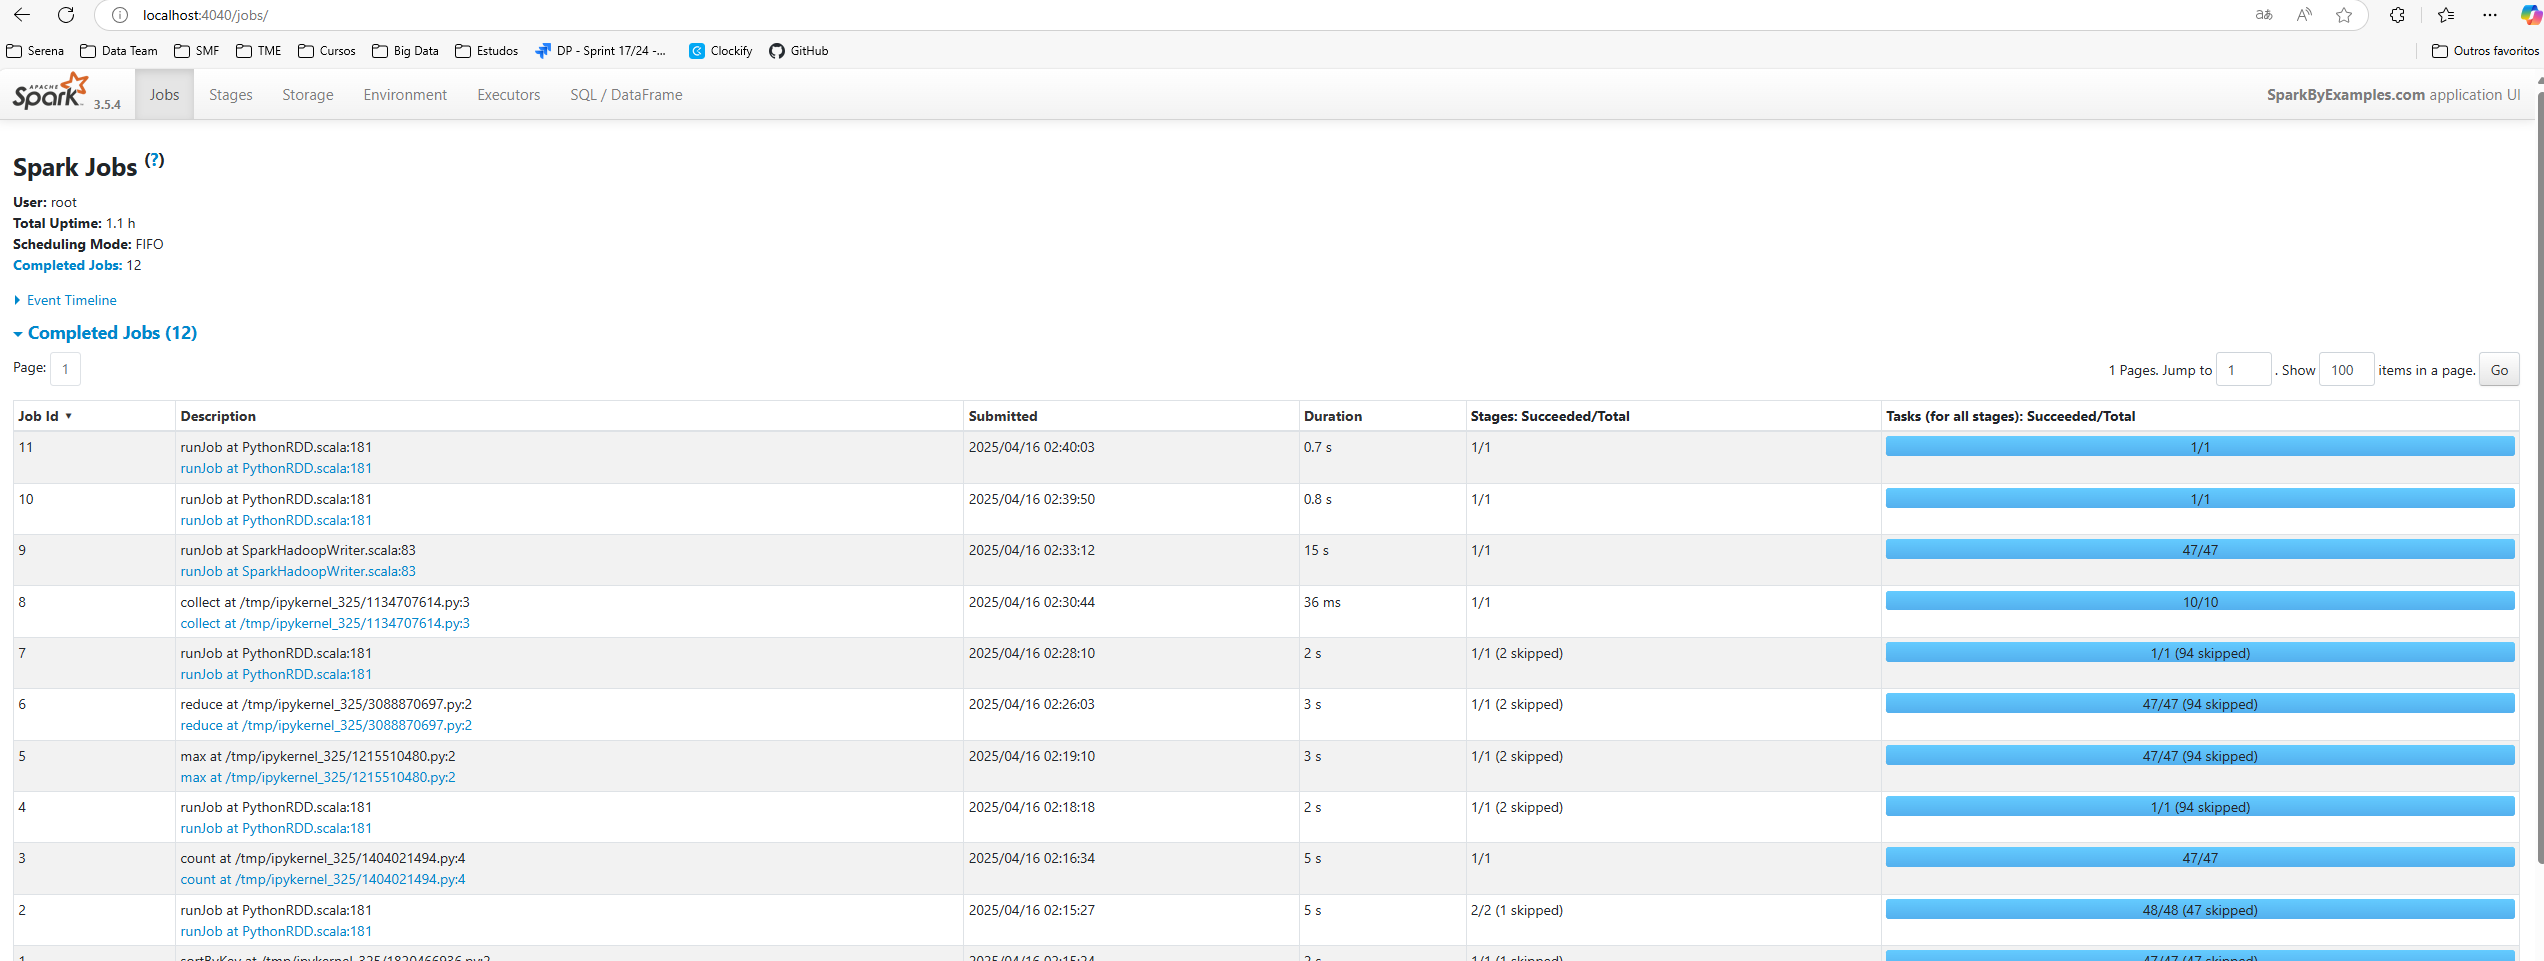

# Stages

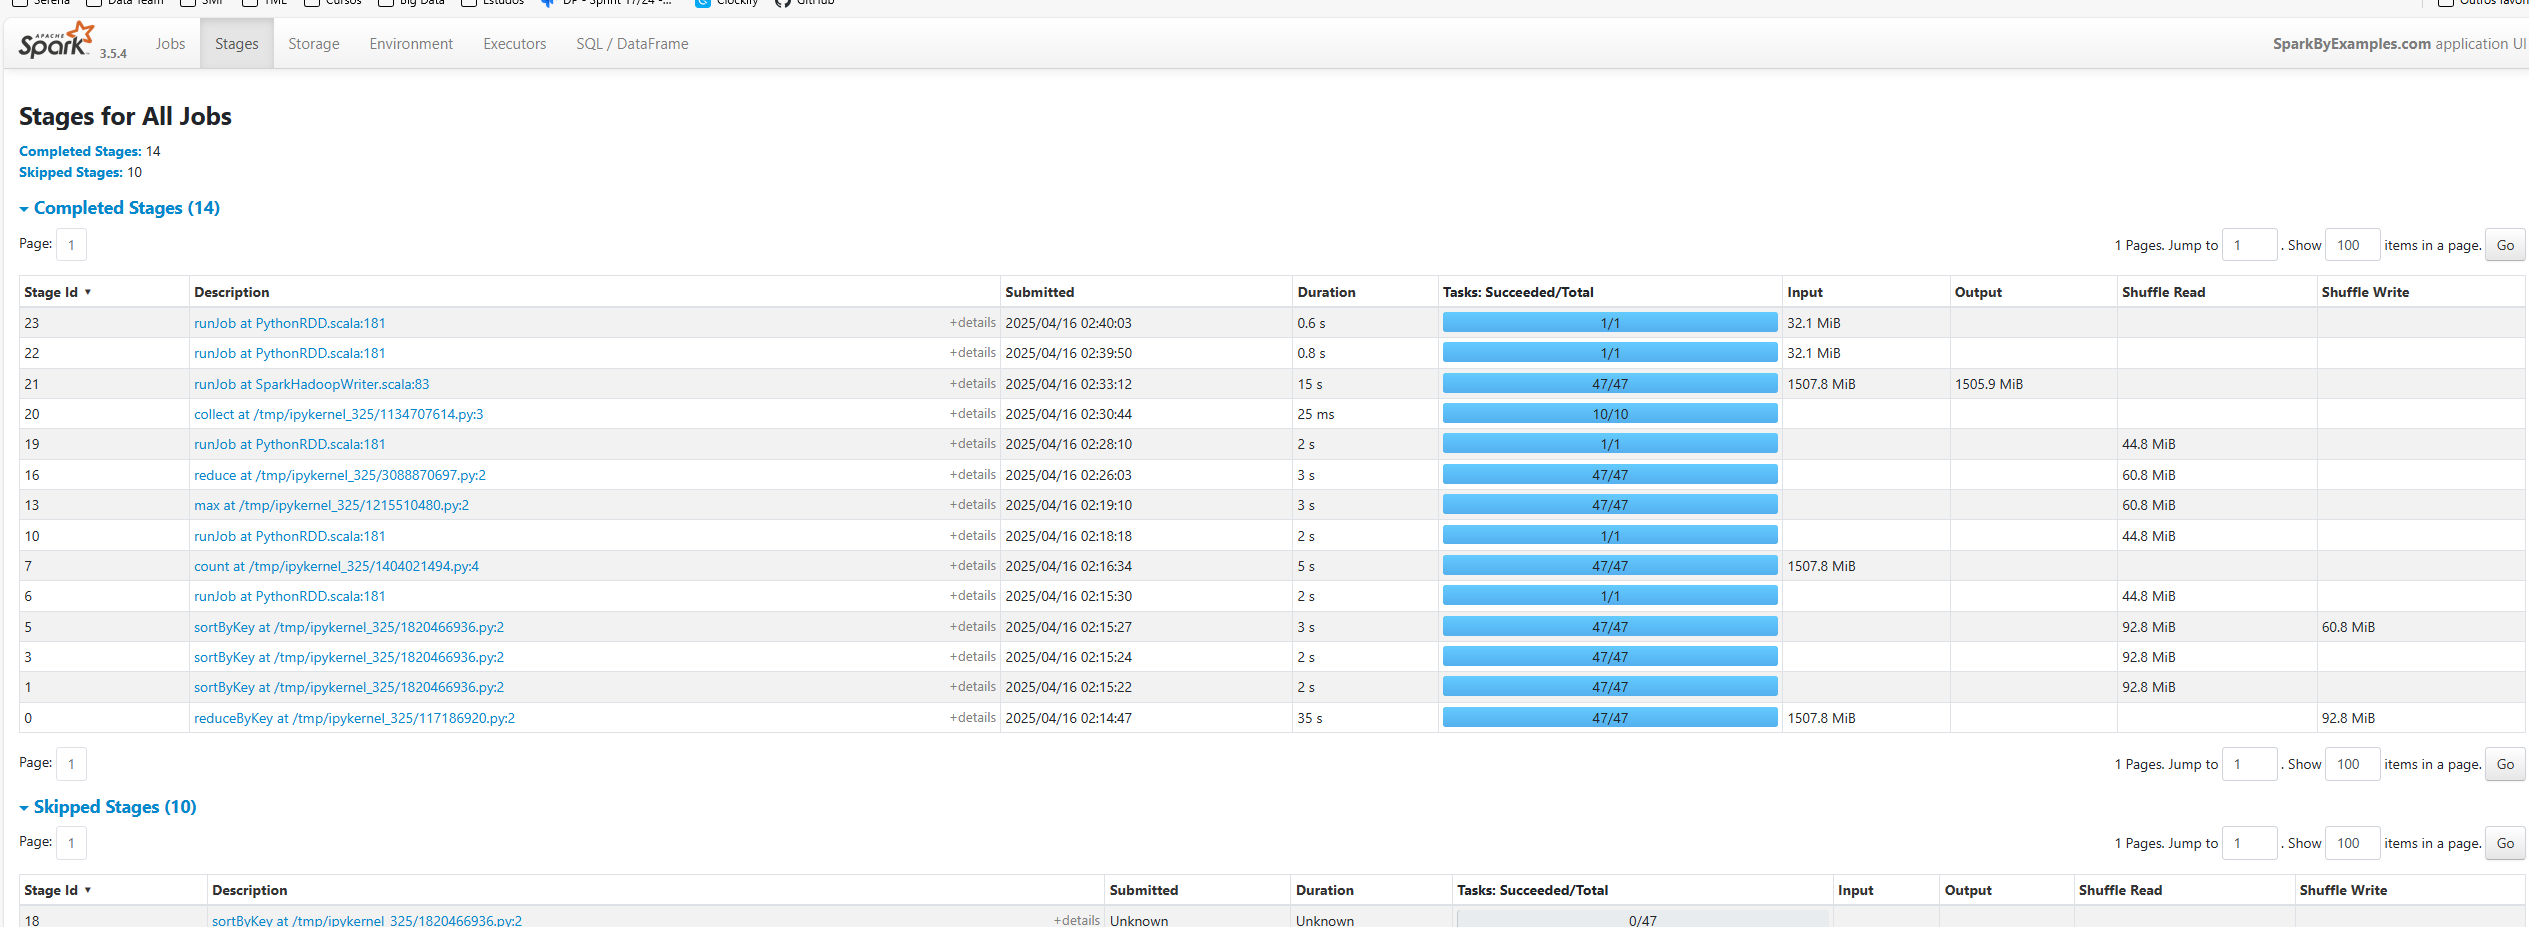

# Storage

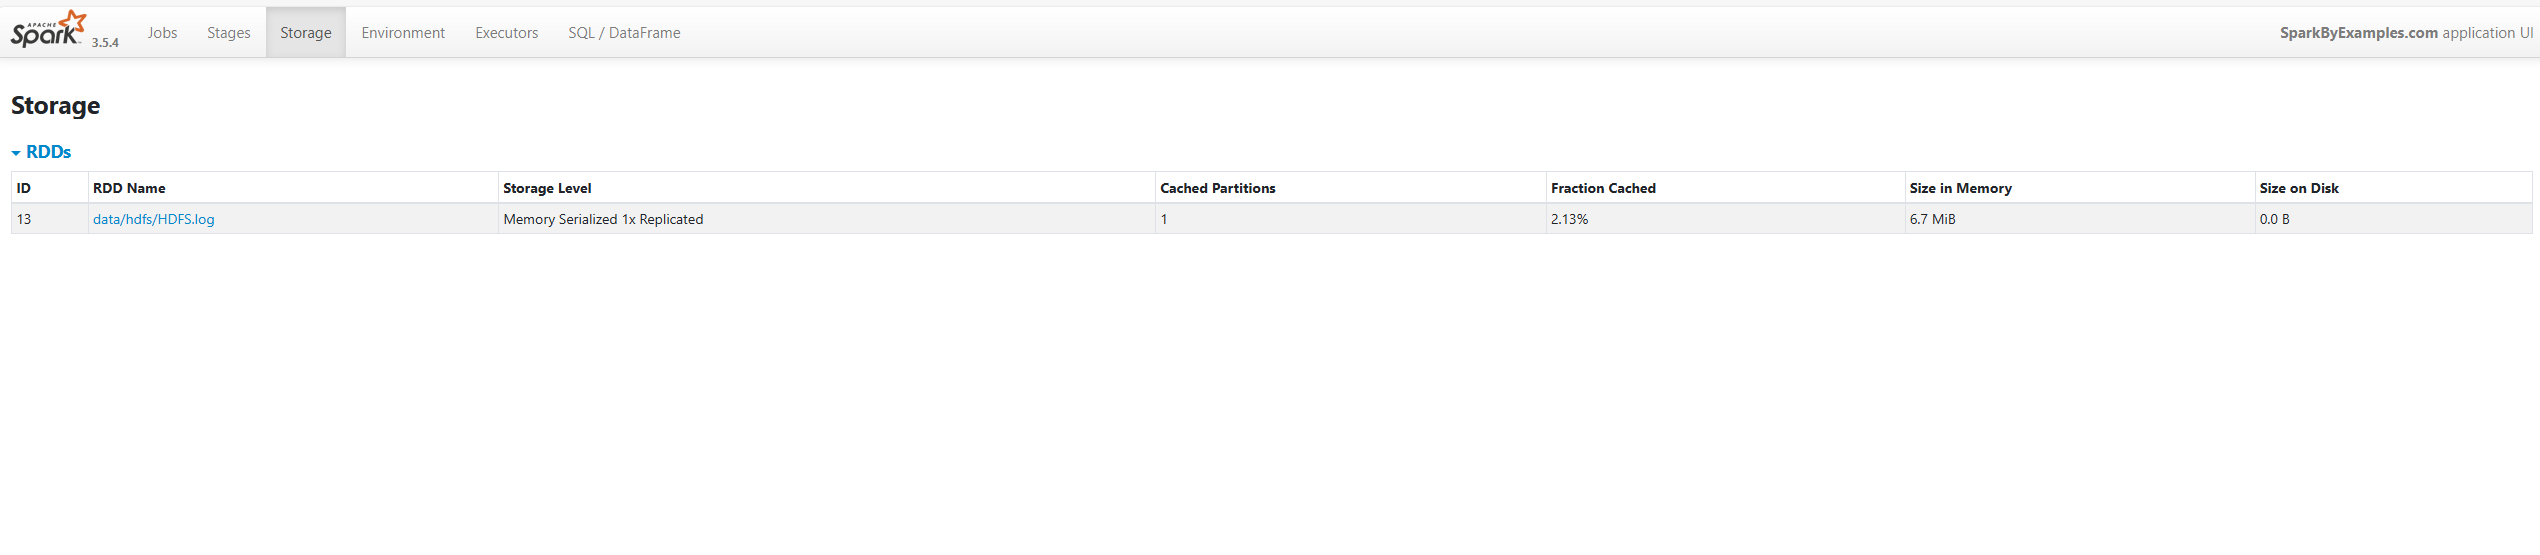

# Executors

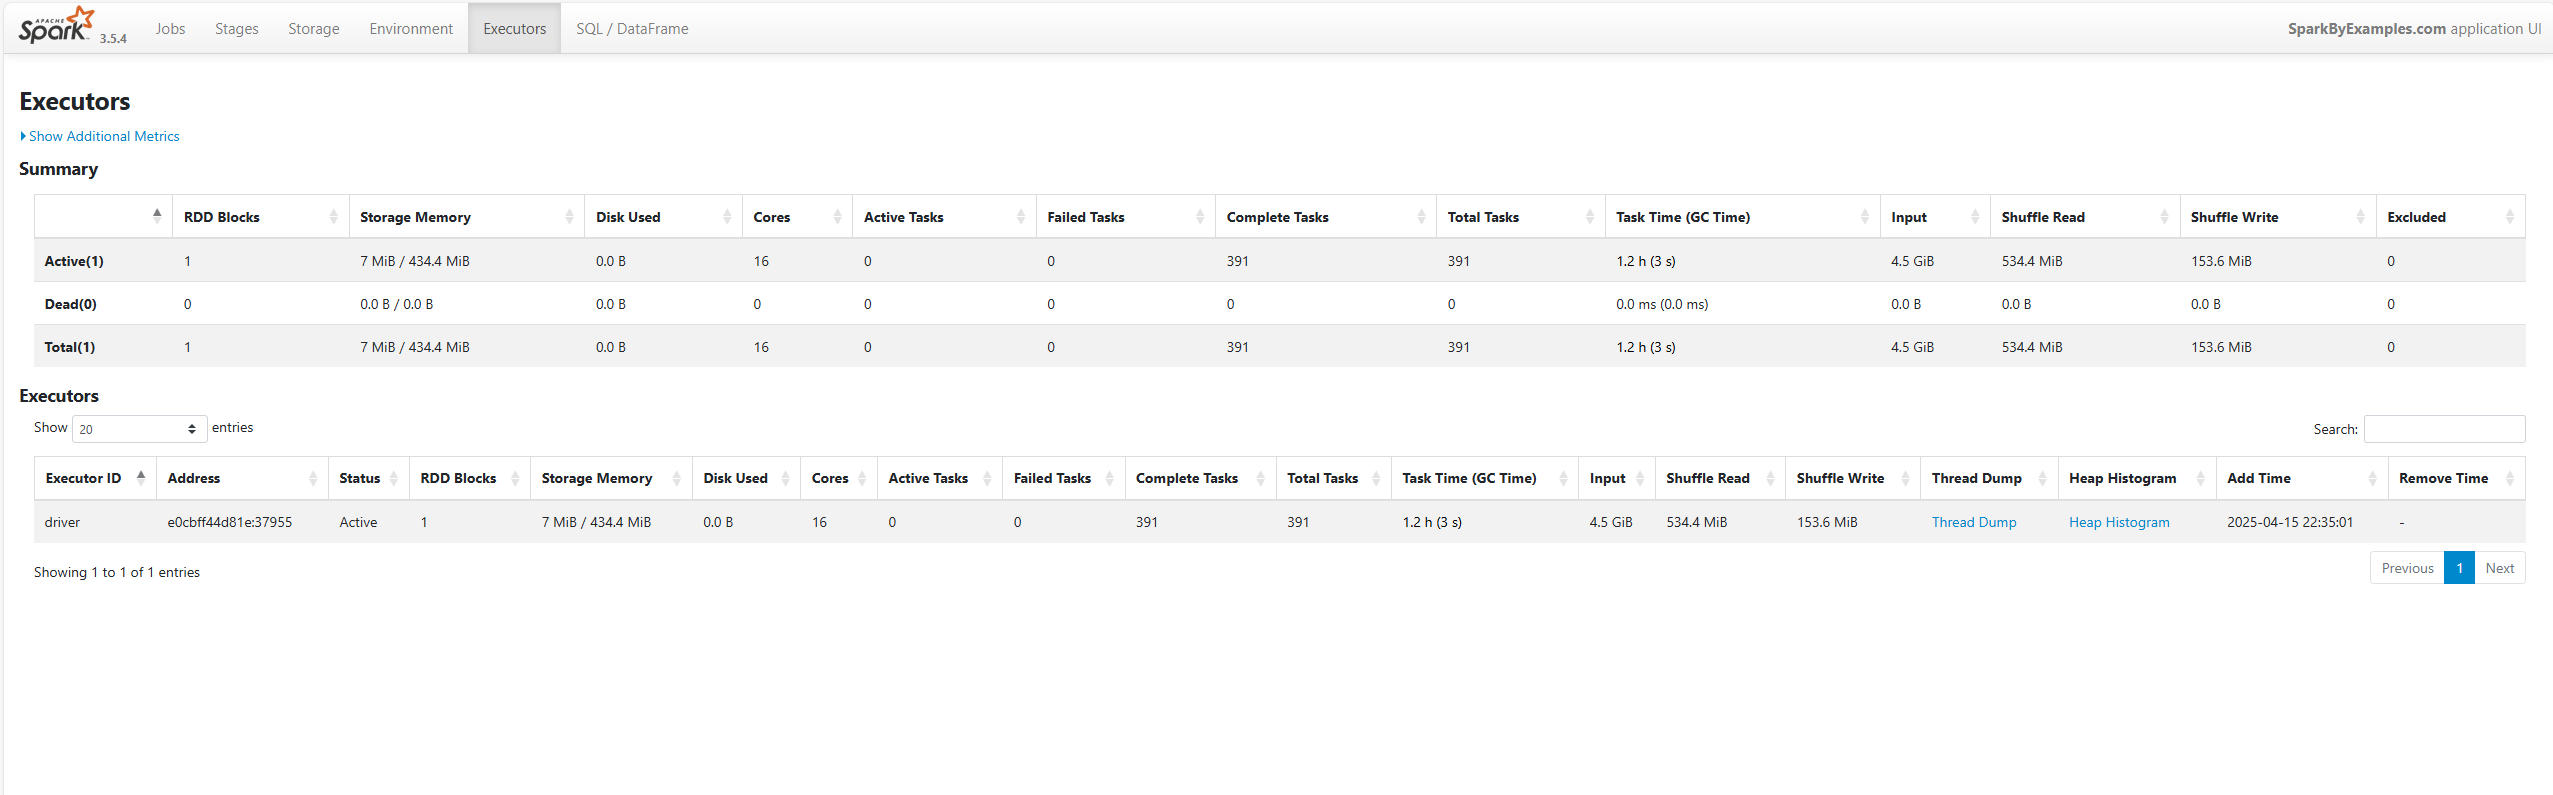